# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
from cycler import cycler

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

from scipy.optimize import root_scalar

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

### General graphing functions

In [4]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min = 40


In [5]:
def plot_confidence_int(ax, time_arr, mean, std_dev, num_runs=12, color='b', ci=.95, label='Mean'):
    degrees_freedom = num_runs - 1
    confidence_interval = stats.t.ppf((1 + ci) / 2., degrees_freedom) * std_dev / np.sqrt(num_runs)

    _ = ax.plot(time_arr, mean, label=label, color=color)
    _ = ax.fill_between(time_arr, mean - confidence_interval, mean + confidence_interval, color=color, alpha=.1)

In [19]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin5.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin5.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin5.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin5.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin5.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin5.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin5.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin5.0um/",
                  }

fig, axarr = plt.subplots(3, 2, figsize=(24, 18), sharex='col', sharey='row')
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]

        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        num_runs = h5_data.attrs['num_runs']

        # beads in condenates
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr[0,0], time_arr[1:min_length], mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label)
        plot_confidence_int(axarr[0,1], time_arr[1:min_length]*kod, mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label)
        plot_confidence_int(axarr[1,0], time_arr[1:min_length], mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label)

        #

    _ = axarr[0,0].set_ylabel('Condensed chain fraction')
    _ = axarr[0,0].set_xscale('log')
    _ = axarr[0,1].set_xscale('log')

    # _ = axarr.legend(loc='center right', bbox_to_anchor=(1, .4))

    # _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    fig.tight_layout()


TypeError: subplots() got an unexpected keyword argument 'figsize'

<Figure size 432x288 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


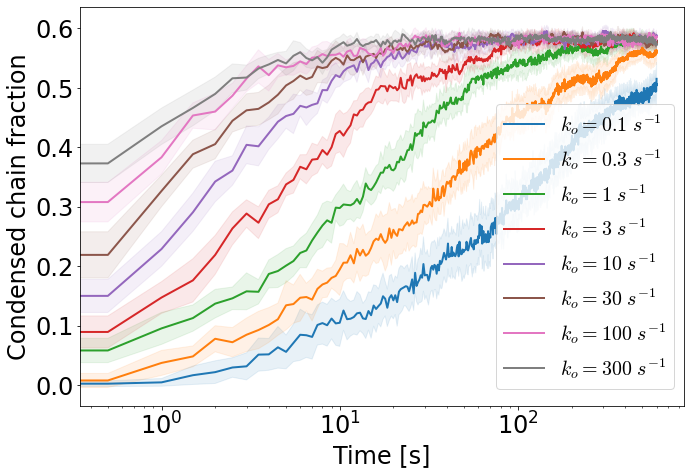

In [6]:
labels_to_graph_dict = {
                # 'Baseline': "kod30_Pin5.0um/", 
                #   r'$L_{sep} = 3~\mu {\rm m}$' :"kod30_Pin3.0um",
                #   r'$L_{sep} = 9~\mu {\rm m}$' : "Pin9.0um_Ke30",
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin5.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin5.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin5.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin5.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin5.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin5.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin5.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin5.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs['num_runs']
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length], mean/1600, std_dev/1600, num_runs, color=color, label=label)


    _ = axarr.set_ylabel('Condensed chain fraction')
    _ = axarr.set_xscale('log')
    _ = axarr.legend(loc='center right', bbox_to_anchor=(1, .4))

    _ = axarr.set_xlabel('Time [s]')
    fig.tight_layout()


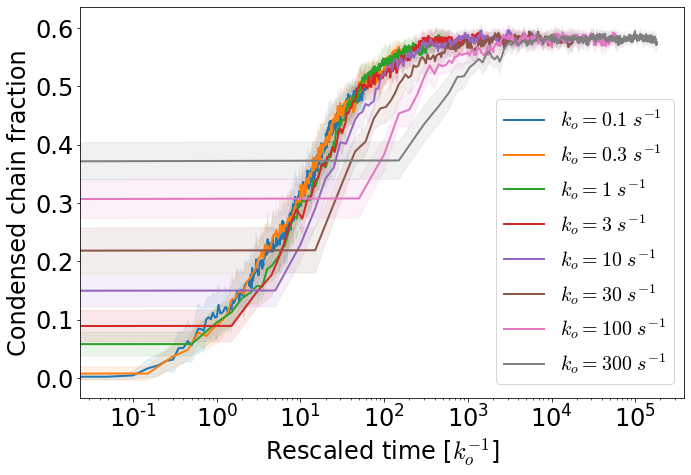

In [31]:
labels_to_graph_dict = {
                # 'Baseline': "kod30_Pin5.0um/", 
                #   r'$L_{sep} = 3~\mu {\rm m}$' :"kod30_Pin3.0um",
                #   r'$L_{sep} = 9~\mu {\rm m}$' : "Pin9.0um_Ke30",
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin5.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin5.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin5.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin5.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin5.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin5.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin5.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin5.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        # Get the float number of kod using regular expressions

        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        num_runs = h5_data.attrs['num_runs']
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length]*kod, mean/1600, std_dev/1600, num_runs, color=color, label=label)


    _ = axarr.set_ylabel('Condensed chain fraction')
    _ = axarr.set_xscale('log')
    _ = axarr.legend(loc='center right', bbox_to_anchor=(1, .4))

    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    fig.tight_layout()


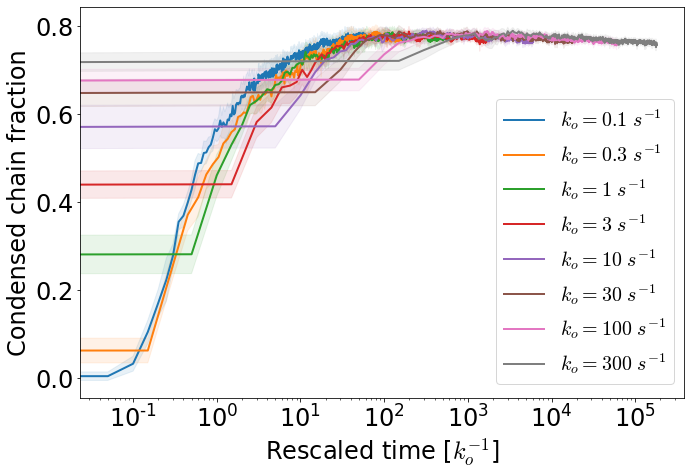

In [32]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin3.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin3.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin3.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin3.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin3.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin3.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin3.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin3.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        # Get the float number of kod using regular expressions

        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        num_runs = h5_data.attrs['num_runs']
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length]*kod, mean/1600, std_dev/1600, num_runs, color=color, label=label)


    _ = axarr.set_ylabel('Condensed chain fraction')
    _ = axarr.set_xscale('log')
    _ = axarr.legend(loc='center right', bbox_to_anchor=(1, .4))

    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    fig.tight_layout()


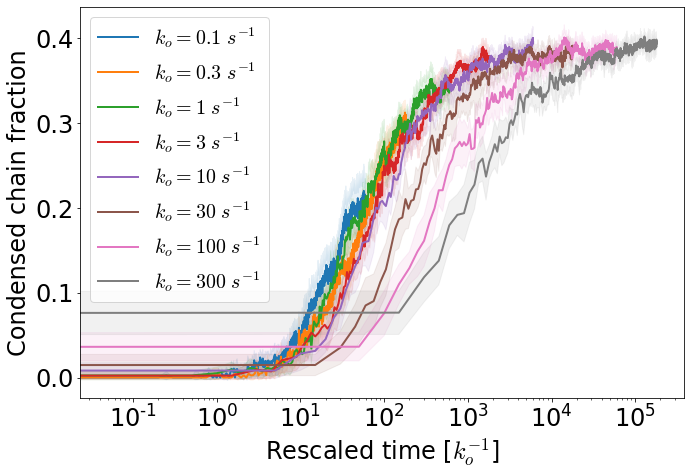

In [36]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin7.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin7.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin7.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin7.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin7.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin7.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin7.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin7.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        # Get the float number of kod using regular expressions

        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        num_runs = h5_data.attrs['num_runs']
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length]*kod, mean/1600, std_dev/1600, num_runs, color=color, label=label)


    _ = axarr.set_ylabel('Condensed chain fraction')
    _ = axarr.set_xscale('log')
    _ = axarr.legend()
    # _ = axarr.legend(loc='center right', bbox_to_anchor=(1, .4))

    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    fig.tight_layout()


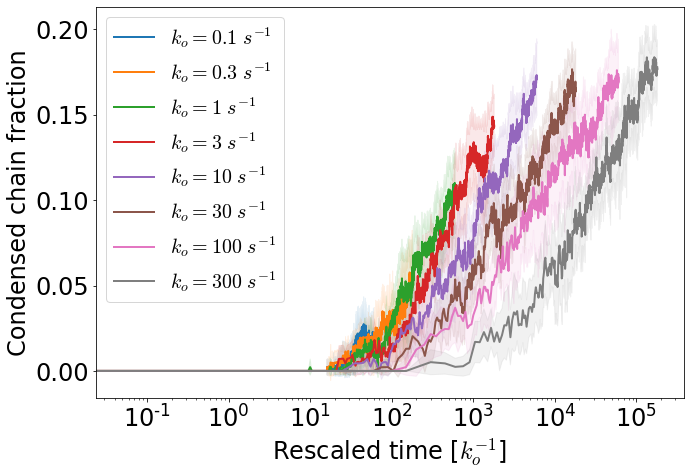

In [35]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin9.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin9.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin9.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin9.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin9.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin9.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin9.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin9.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        # Get the float number of kod using regular expressions

        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        num_runs = h5_data.attrs['num_runs']
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length]*kod, mean/1600, std_dev/1600, num_runs, color=color, label=label)


    _ = axarr.set_ylabel('Condensed chain fraction')
    _ = axarr.set_xscale('log')
    # _ = axarr.legend(loc='center right', bbox_to_anchor=(1, .4))
    _ = axarr.legend()

    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    fig.tight_layout()


# Cluster number

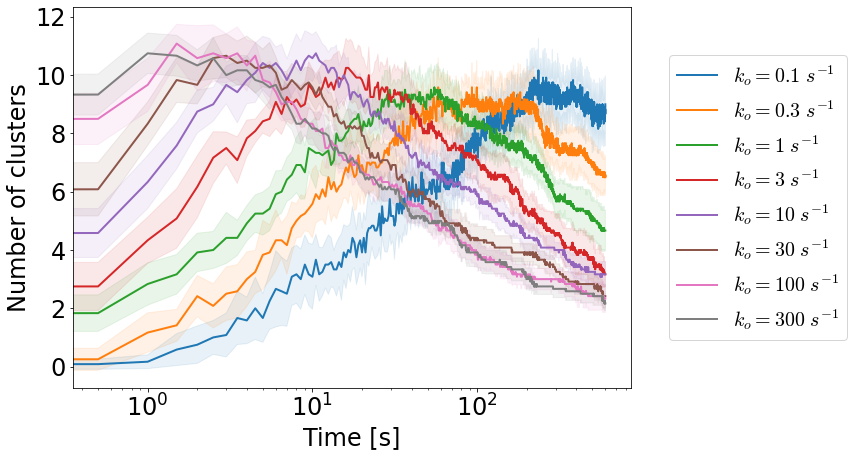

In [44]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin5.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin5.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin5.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin5.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin5.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin5.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin5.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin5.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length], mean, std_dev, num_runs, color=color, label=label)

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel('Number of clusters')
    _ = axarr.set_xlabel('Time [s]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    # fig.tight_layout()



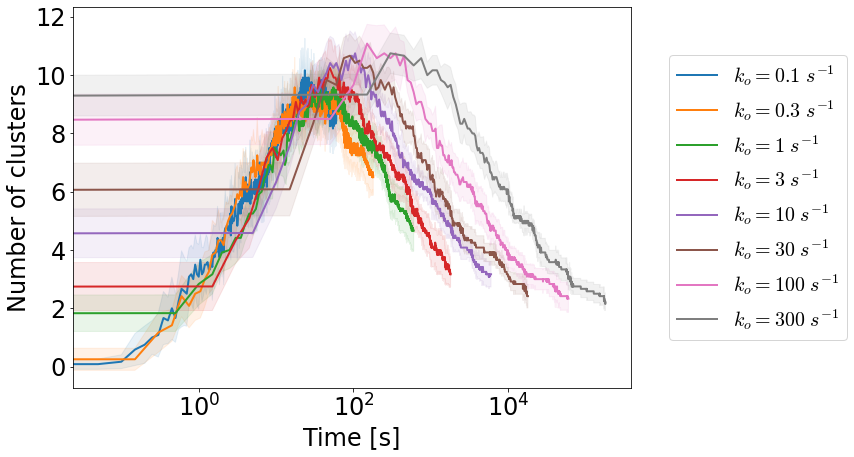

In [45]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin5.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin5.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin5.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin5.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin5.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin5.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin5.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin5.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length]*kod, mean, std_dev, num_runs, color=color, label=label)

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel('Number of clusters')
    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig.tight_layout()



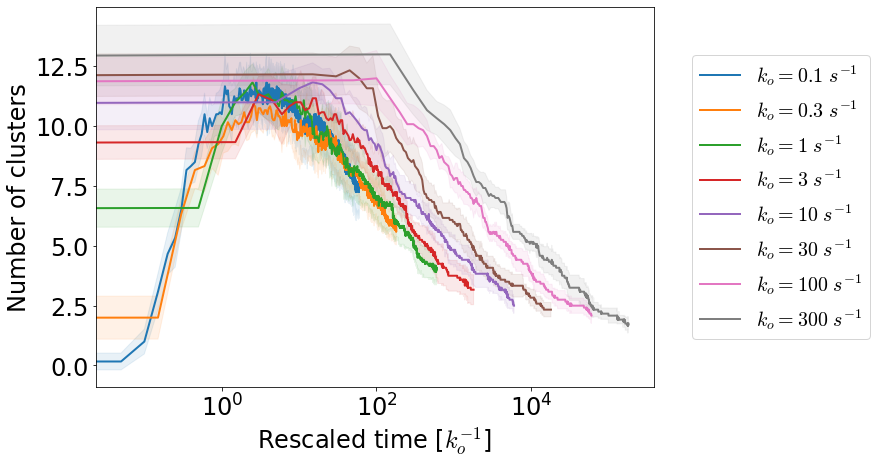

In [62]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin3.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin3.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin3.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin3.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin3.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin3.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin3.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin3.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length]*kod, mean, std_dev, num_runs, color=color, label=label)

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel('Number of clusters')
    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig.tight_layout()



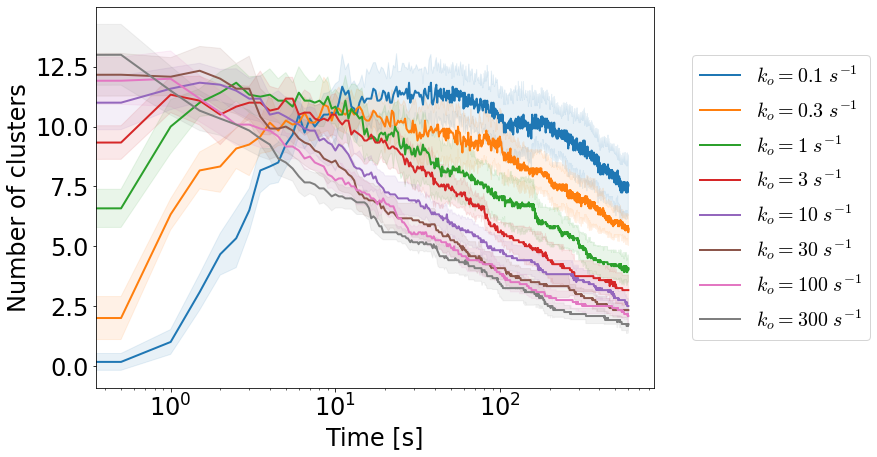

In [65]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin3.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin3.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin3.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin3.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin3.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin3.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin3.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin3.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length], mean, std_dev, num_runs, color=color, label=label)

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel('Number of clusters')
    _ = axarr.set_xlabel('Time [s]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig.tight_layout()



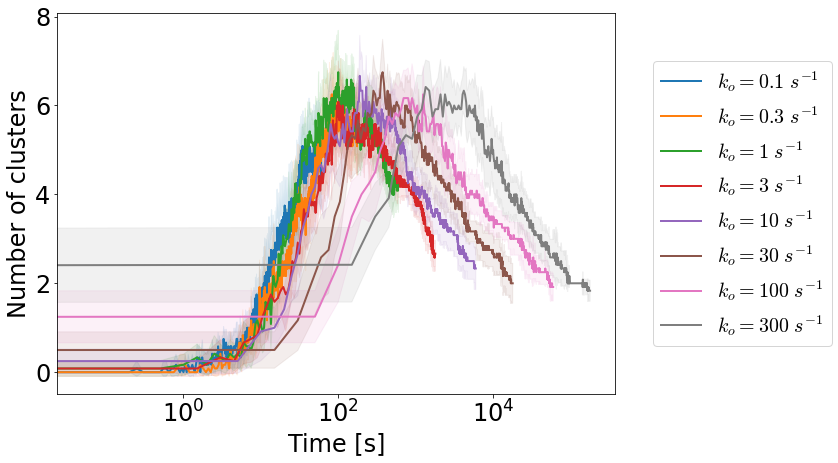

In [47]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin7.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin7.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin7.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin7.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin7.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin7.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin7.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin7.0um/",
                  }


fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length]*kod, mean, std_dev, num_runs, color=color, label=label)

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel('Number of clusters')
    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig.tight_layout()



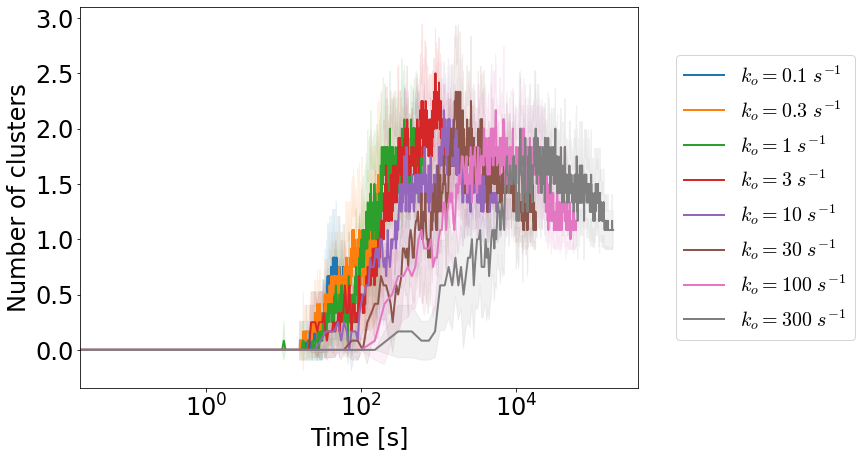

In [48]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin9.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin9.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin9.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin9.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin9.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin9.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin9.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin9.0um/",
                  }


fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr, time_arr[:min_length]*kod, mean, std_dev, num_runs, color=color, label=label)

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel('Number of clusters')
    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # fig.tight_layout()



# Max beads in clusters

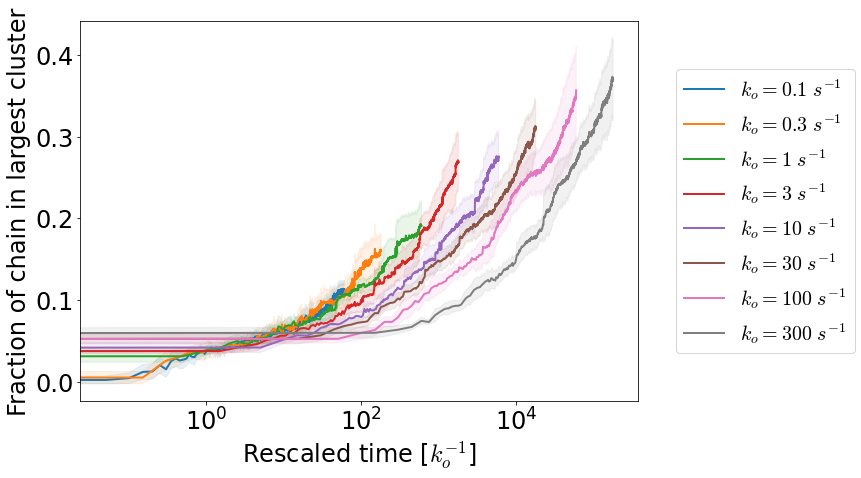

In [56]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin5.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin5.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin5.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin5.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin5.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin5.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin5.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin5.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr, time_arr[:min_length]*kod, mean/1600, std_dev/1600, num_runs, color=color, label=label
        )

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel("Fraction of chain in largest cluster")
    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    # fig.tight_layout()



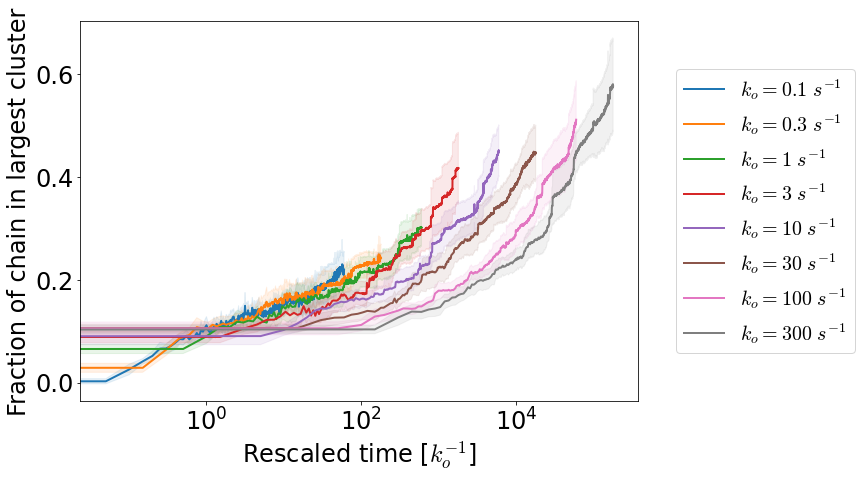

In [57]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin3.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin3.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin3.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin3.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin3.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin3.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin3.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin3.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr, time_arr[:min_length]*kod, mean/1600, std_dev/1600, num_runs, color=color, label=label
        )

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel("Fraction of chain in largest cluster")
    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    # fig.tight_layout()



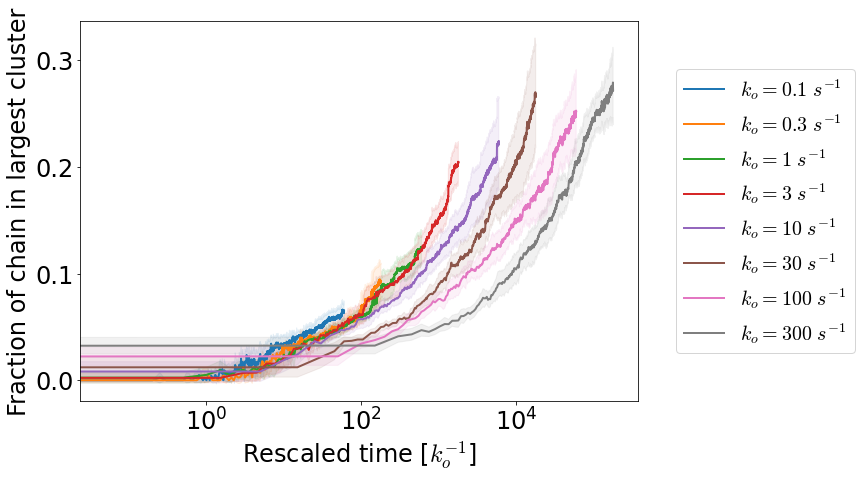

In [58]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin7.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin7.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin7.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin7.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin7.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin7.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin7.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin7.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr, time_arr[:min_length]*kod, mean/1600, std_dev/1600, num_runs, color=color, label=label
        )

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel("Fraction of chain in largest cluster")
    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    # fig.tight_layout()



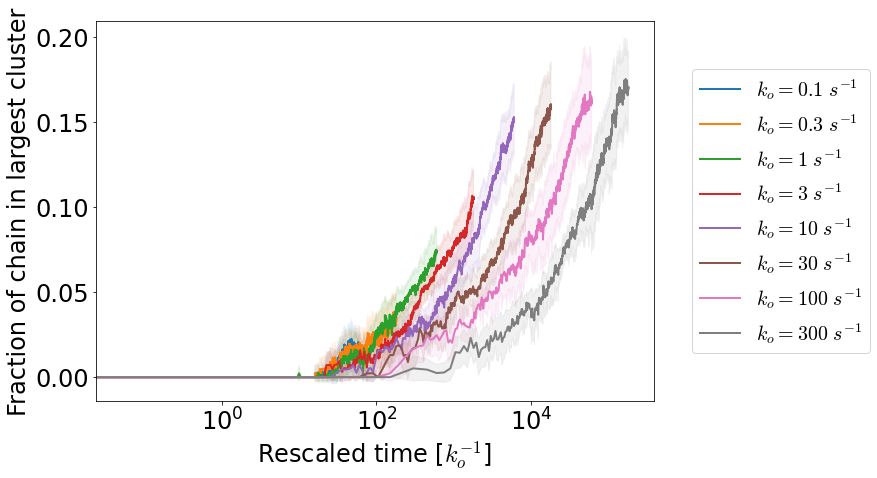

In [60]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin9.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin9.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin9.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin9.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin9.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin9.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin9.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin9.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr, time_arr[:min_length]*kod, mean/1600, std_dev/1600, num_runs, color=color, label=label
        )

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel("Fraction of chain in largest cluster")
    _ = axarr.set_xlabel('Rescaled time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    # fig.tight_layout()



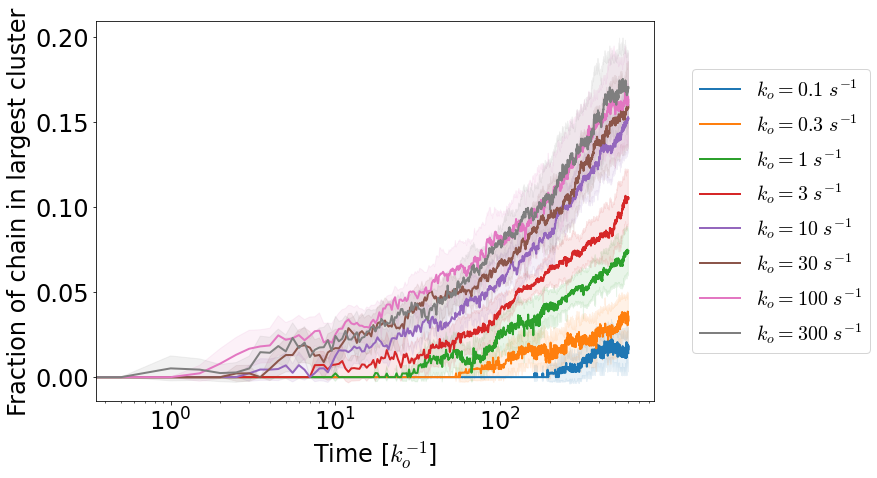

In [61]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin9.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin9.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin9.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin9.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin9.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin9.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin9.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin9.0um/",
                  }

fig, axarr = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]
        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr, time_arr[:min_length], mean/1600, std_dev/1600, num_runs, color=color, label=label
        )

    _ = axarr.set_xscale('log')
    _ = axarr.set_ylabel("Fraction of chain in largest cluster")
    _ = axarr.set_xlabel('Time [$k_o^{-1}$]')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    
    # fig.tight_layout()



In [8]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# Cluster analysis
sim_path = data_path / 'simulations/Ke30_Pin5.0um/'
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []
num_max_cluster_beads_list = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    # Secondary thresholding
    # clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > 40]
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    max_beads = 0
    for i, clust in enumerate(clust_grp):
        flat_time_arr += [clust.time]
        flat_clust_cent_arr += [clust.center]
        flat_clust_ind_arr += [clust.part_ids]

        num_beads += len(clust.part_ids)
        max_beads = max(max_beads, len(clust.part_ids))
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]

    num_cluster_beads_list += [num_beads]
    num_max_cluster_beads_list += [max_beads]
    
# for c, clust_grp in enumerate(clusters):
#     for clust in clust_grp:
#         bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]
# bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
# bead_ind_arr *= .5



(1201,)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


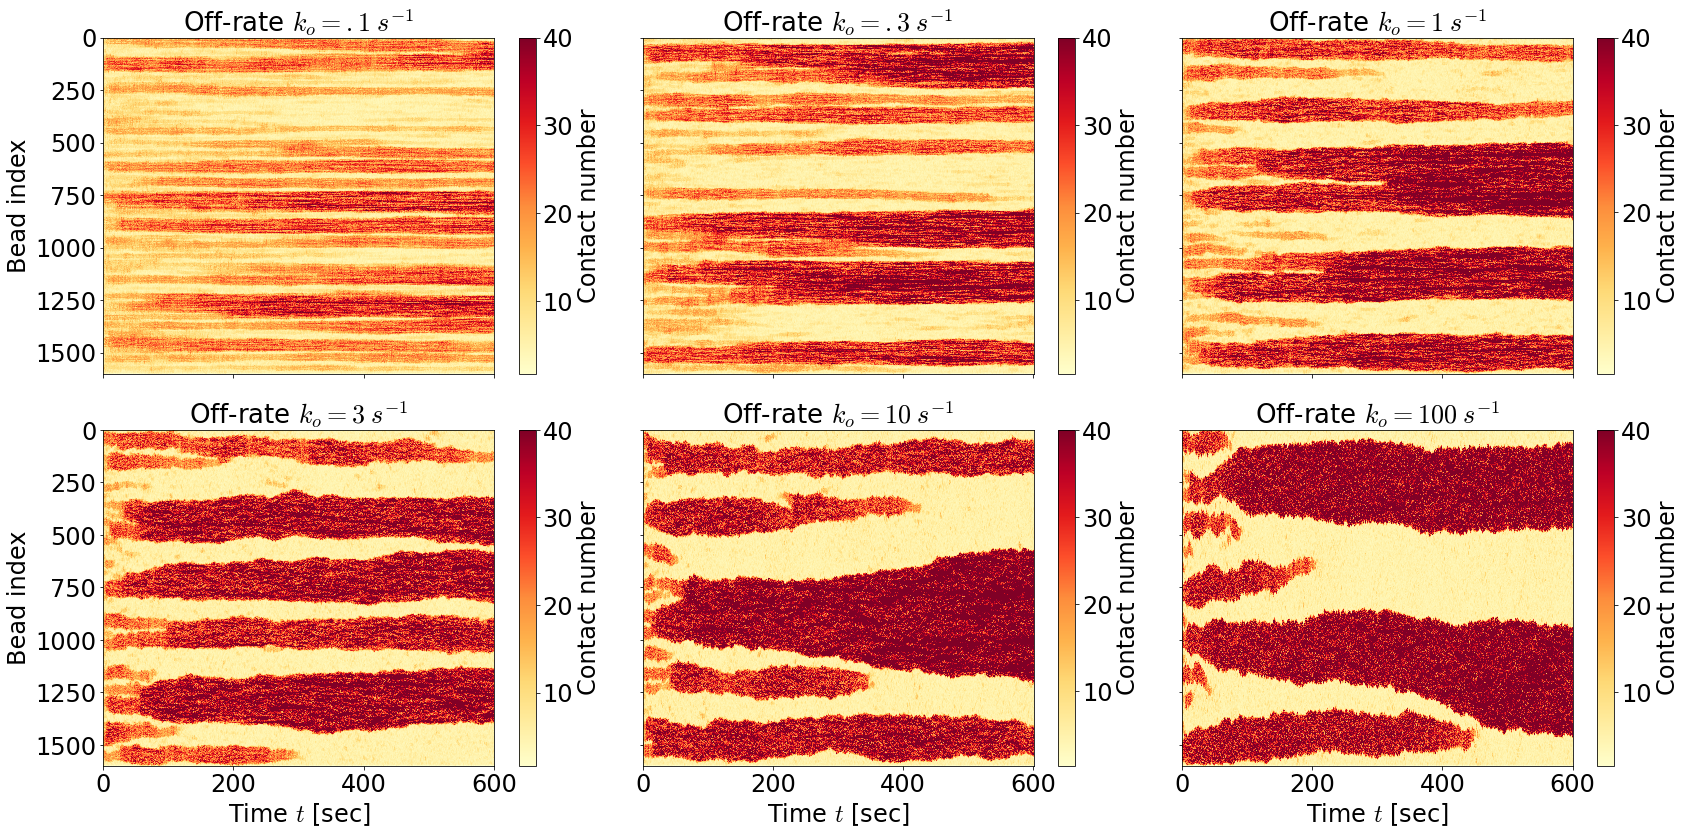

In [33]:
fig, axarr = plt.subplots(2,3, figsize=(24, 12), sharex=True, sharey=True)

title_params = {'fontsize': 26}

kymo_contact_graph(fig, axarr[0,0], 
                   data_path / 'simulations/kod0.1_Pin5.0um')
_ = axarr[0,0].set_title("Off-rate $k_o = .1\;s^{-1}$", **title_params)

# kymo_contact_graph(fig, axarr[1,0],
#                    data_path / 'simulations/kod0.3_Pin5.0um')
# _ = axarr[1,0].set_title("Off-rate $k_o = .3\;s^{-1}$")

kymo_contact_graph(fig, axarr[0,1],
                   data_path / 'simulations/kod0.3_Pin5.0um')
_ = axarr[0,1].set_title("Off-rate $k_o = .3\;s^{-1}$", **title_params)

kymo_contact_graph(fig, axarr[0,2],
                   data_path / 'simulations/kod1_Pin5.0um')
_ = axarr[0,2].set_title("Off-rate $k_o = 1\;s^{-1}$", **title_params)

# _ = axarr[2,0].set_title("End-to-end distance = 5.0 $\mu$m")
# kymo_contact_graph(fig, axarr[0,1],
#                    data_path / 'simulations/kod30_Pin5.0um')
# _ = axarr[0,1].set_title("End-to-end distance = 7.0 $\mu$m")

kymo_contact_graph(fig, axarr[1,0],
                   data_path / 'simulations/kod3_Pin5.0um')
_ = axarr[1,0].set_title("Off-rate $k_o = 3\;s^{-1}$", **title_params)

kymo_contact_graph(fig, axarr[1,1],
                   data_path / 'simulations/kod10_Pin5.0um')
_ = axarr[1,1].set_title("Off-rate $k_o = 10\;s^{-1}$", **title_params)

kymo_contact_graph(fig, axarr[1,2],
                   data_path / 'simulations/kod100_Pin5.0um')
_ = axarr[1,2].set_title("Off-rate $k_o = 100\;s^{-1}$", **title_params)

# kymo_contact_graph(fig, axarr[2,1],
#                    data_path / 'simulations/kod300_Pin5.0um')
# _ = axarr[2,1].set_title("End-to-end distance = 11.0 $\mu$m")

for ax in axarr[:,0]:
    _ = ax.set_ylabel("Bead index")

for ax in axarr[1,:]:
    _ = ax.set_xlabel("Time $t$ [sec]")

fig.tight_layout()

Now this is what I wanted to see! We see different modes of formation when we vary the kinetic rate because we have introduced a timescale that competes with the chain relaxation timescale. Now if I take the 5um simulations and run those with replicates, I think I could match to past results and understand the change in dynamic modes.

In [23]:
# Functions
def free_energy_droplet(Ld, mu, alpha, gamma):
    return -mu*alpha*Ld + gamma * 4. * np.pi * np.power(3.*alpha*Ld/(4*np.pi), 2./3.)

def free_energy_polymer(Ld, Ltot, Lsep, kappa):
    eps = Ltot - Ld
    return .25* kappa* ((eps /(1.-(Lsep/eps))) - Lsep + 2.*((Lsep*Lsep)/eps) - eps)

def tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return free_energy_droplet(Ld, mu, alpha, gamma) + free_energy_polymer(Ld, Ltot, Lsep, kappa)

def free_energy_deriv(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return -mu*alpha + (1./12.) * (8.*np.power(6.*alpha, 2./3.)*gamma*np.power(np.pi/Ld, 1./3.) + 3.*kappa*(Lsep**2)*(2./np.power(Ld-Ltot, 2.) + 1./np.power(Lsep + Ld - Ltot, 2.)))

def length_prob_unnorm(Ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=1./.0041):
    return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
    # return tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)

def partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=1./.0041):
    return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))

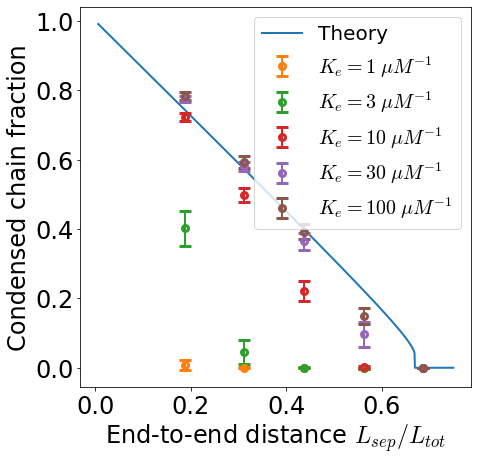

In [14]:
# Parameters (from Renger et al.)
# mu = 11. # Free energy per volume pN/um^2
# alpha = .05 # Condensate packing factor per length um^2 
# gamma = .15 # Surface tension pN/um
# kappa = .0822 # Filament flexibility pN
# Ltot = 16.5 # Total length of the polymer um

mu = 4.1 # Free energy per volume pN/um^2
alpha = .05 # Condensate packing factor um^2 
gamma = .15 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16.0 # Total length of the polymer um

beta = 1./.0041
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))


# Get theoretical results
lsep_arr = np.linspace(.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size) 
for i, lsep in enumerate(lsep_arr):
    bound = .1
    while free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa) > 0:
        bound += .5
    if bound > Ltot-(lsep*1.0000001):
        ld_max_prob[i] = 0.
        continue
    # free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa)
    # free_energy_deriv(Ltot-(lsep*1.0000001), Ltot, lsep, mu, alpha, gamma, kappa)
    result = root_scalar(free_energy_deriv, method='brentq', bracket=[bound, Ltot-(lsep*1.0000001)], args=(Ltot, lsep, mu, alpha, gamma, kappa))
    ld_max_prob[i] = result.root
_ = axarr.plot(lsep_arr/Ltot, ld_max_prob/Ltot, label='Theory')
_ = axarr.set_xlabel(r'End-to-end distance $L_{sep}/L_{tot}$')
_ = axarr.set_ylabel(r'Condensed chain fraction')

with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    
    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 1:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(np.array(pin_dist_arr)/16, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=6, markerfacecolor='none', capsize=6, label='$K_e = 1\;\mu M^{-1}$')

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 3:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(np.array(pin_dist_arr)/16, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=6, markerfacecolor='none', capsize=6, label='$K_e = 3\;\mu M^{-1}$')


    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 10:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(np.array(pin_dist_arr)/16, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=6, markerfacecolor='none', capsize=6, label='$K_e = 10\;\mu M^{-1}$')

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(np.array(pin_dist_arr)/16, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=6, markerfacecolor='none', capsize=6, label='$K_e = 30\;\mu M^{-1}$')

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 100:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(np.array(pin_dist_arr)/16, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=6, markerfacecolor='none', capsize=6, label='$K_e = 100\;\mu M^{-1}$')

_ = axarr.legend()


# Collect data

In [ ]:
slice_path = ceph_path / "DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations"

pin_ko_data_dict = {}


def parse_params(param_dir):
    data_path = next(param_dir.glob("s*")) / "analysis/raw_data.h5"
    with h5py.File(data_path, "r") as h5_data:
        run_params = yaml.safe_load(h5_data.attrs["RunConfig"])
        prot_params = yaml.safe_load(h5_data.attrs["ProteinConfig"])

    return run_params["pinDist"], prot_params["proteins"][0]["ko_d"][1]


for param_dir in slice_path.glob("*"):
    print(param_dir)
    try:
        pin_dist, ko = parse_params(param_dir)
        if pin_dist not in pin_ko_data_dict:
            pin_ko_data_dict[pin_dist] = {}


        sd_h5_file_lst = [h5p for h5p in param_dir.glob("s*/analysis/raw_data.h5")]

        num_runs = len(sd_h5_file_lst)
        min_run_length = min(
            [len(h5py.File(h5p, "r")["time"]) for h5p in sd_h5_file_lst]
        )
        with h5py.File(sd_h5_file_lst[0], "r") as h5d:
            time_arr = h5d["time"][ss_ind:end_ind]
            nbeads = h5d["raw_data"]["sylinders"][start_bead:end_bead, 0, 0].shape[0]

        avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
        avg_max_num_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
        avg_num_clust_arr = np.zeros((len(sd_h5_file_lst), min_run_length))

        for ih, h5d in enumerate(sd_h5_file_lst):
            h5_clust_file = h5d.parent / "cluster_analysis.h5"
            with h5py.File(h5_clust_file, "r") as h5_data:
                cluster_grp = h5_data["clusters"]
                time_grp_list = sorted(
                    cluster_grp.values(), key=lambda x: x.attrs["time"]
                )
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data=c) for c in tg.values()]]

            # assert len(clusters) == time_arr.size

            for c, clust_grp in enumerate(clusters):
                if c >= min_run_length:
                    break
                # Secondary thresholding
                clust_grp = [
                    clust for clust in clust_grp if len(clust.part_ids) > part_min
                ]

                num_beads = 0
                max_beads = 0
                for i, clust in enumerate(clust_grp):
                    num_beads += len(clust.part_ids)
                    max_beads = max(max_beads, len(clust.part_ids))

                avg_num_clust_arr[ih, c] = len(clust_grp)
                avg_num_clust_beads_arr[ih, c] += num_beads
                avg_max_num_beads_arr[ih, c] = max_beads

        num_bead_mean = avg_num_clust_beads_arr.mean(axis=0)
        num_bead_std_dev = avg_num_clust_beads_arr.std(axis=0)
        num_clust_mean = avg_num_clust_arr.mean(axis=0)
        num_clust_std_dev = avg_num_clust_arr.std(axis=0)
        max_num_bead_mean = avg_max_num_beads_arr.mean(axis=0)
        max_num_bead_std_dev = avg_max_num_beads_arr.std(axis=0)
        pin_ko_data_dict[pin_dist][ko] = [
            num_bead_mean,
            num_bead_std_dev,
            num_clust_mean,
            num_clust_std_dev,
            max_num_bead_mean,
            max_num_bead_std_dev,
            num_runs,
        ]

    except:
        raise
        print("Error occured")

/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod30_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod0.1_Pin3.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod100_Pin3.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod0.3_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod0.3_Pin3.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulatio

In [ ]:
# Store pin_ke_data_dict as an hdf5 file
# with h5py.File('Figure6/fig6_pin_ko_data_dict.h5', 'w') as h5d:
#     _ = h5d.create_dataset('time', data=time_arr)
#     for pin_dist, ko_data in pin_ko_data_dict.items():
#         for ko, data in ko_data.items():
#             dset = h5d.create_dataset(f'kod{ko:.3g}_Pin{pin_dist:.1f}um', data=np.vstack(data[:-1]).T)
#             dset.attrs['pin_dist'] = pin_dist
#             dset.attrs['ko'] = ko
#             dset.attrs['num_runs'] = data[-1]